### Instituto Tecnológico de Costa Rica (ITCR)
### Escuela de Computación
### Curso: Inteligencia Artificial
 
### Cuarta tarea programada 2022-I


Estudiantes: Juan Ignacio Navarro Navarro

### 1.1) Implementación del algoritmo K-means sin bibliotecas

Importación de la librerías necesarias para mostrar los resultados del análisis.

In [306]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from numpy.random import uniform
from sklearn.datasets import make_blobs
import seaborn as sns
import random
import pandas as pd
import pandasql as sqldf

Definición de la clase que implementa KMeans. Además también se crea un método que define la función euclidea.

In [331]:
# Funcion para calculo de la distancia entre puntos
def euclidean(point, data):
    """
    Descipcion: distancia entre puntos de informacion
    para poder realizar la clasificacion en clusters
    al calcular la distancia total con un conjunto de
    puntos

    Entreda:
        point -> es un vector de dimension m que representa un dato
        data -> es arreglo que contiene el resto de los puntos del cluster
    """
    return np.sqrt(np.sum((point - data)**2, axis=1))

# clase para el calculo de K medias
class KMeans:
    def __init__(self, n_clusters=8, max_iter=300):
        """
        Descripcion: se definen los cluster iniciales y un maximo de iteraciones
        en los calculos del algoritmo
        """
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.inertia = 0

    def fit(self, X_train):
        """
        Descripcion: se definen los centroides que son un punto de los dados 
        con respecto a los cuales se calculan las ditancias para conocer si es una
        buena referencia

        input:
            -> X_train : son los datos de entrada del algoritmo
        """

        self.centroids = [random.choice(X_train)]
        for _ in range(self.n_clusters-1):
            # Se calculan las ditancias de los puntos hacia los centroides
            dists = np.sum([euclidean(centroid, X_train) for centroid in self.centroids], axis=0)
            # Se normalizan estas distancias
            dists /= np.sum(dists)
            # Se escogen los puntos restantes basados en estas distancias
            new_centroid_idx, = np.random.choice(range(len(X_train)), size=1, p=dists)
            self.centroids += [X_train[new_centroid_idx]]

            # Define a value por the inertia
            self.inertia = np.sqrt(np.sum((dists)**2))

        # Ahora se itera para ajustar los centroides hasta que converjan
        iteration = 0
        prev_centroids = None
        while np.not_equal(self.centroids, prev_centroids).any() and iteration < self.max_iter:
            # Se ordenan los datos asignangolos al centroide mas cercano
            sorted_points = [[] for _ in range(self.n_clusters)]
            for x in X_train:
                dists = euclidean(x, self.centroids)
                centroid_idx = np.argmin(dists)
                sorted_points[centroid_idx].append(x)
            
            prev_centroids = self.centroids
            self.centroids = [np.mean(cluster, axis=0) for cluster in sorted_points]
            for i, centroid in enumerate(self.centroids):
                if np.isnan(centroid).any():
                    self.centroids[i] = prev_centroids[i]
            iteration += 1

    def evaluate(self, X):
        """
        descripcion: funcion de evaluacion donde se asocian los puntos
        al centroide de su cluster
        """
        centroids = []
        centroid_idxs = []
        for x in X:
            dists = euclidean(x, self.centroids)
            centroid_idx = np.argmin(dists)
            centroids.append(self.centroids[centroid_idx])
            centroid_idxs.append(centroid_idx)
        return centroids, centroid_idxs


Prueba del algortimo con datos generados artificialmente

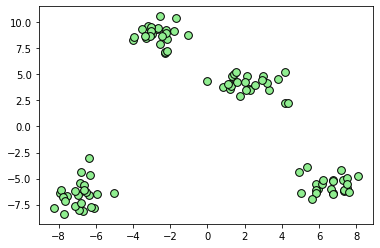

          1         2          3         4  Cluster
0  6.724657 -6.430379  -5.388381 -6.478967        1
1  4.935718 -4.399345  -6.478041 -5.094093        1
2 -6.956729 -6.538958  -8.561637  8.150706        0
3  4.144456  5.193917 -11.107680  8.913963        3
4 -6.357686 -6.583125  -8.587835  7.669971        0


In [308]:
# Se crea un arreglo de datos aleatorios con make_blobs que contiene la cantidad
# de centros indicada junto con la cantidad de caracteristicas dada como features
centers = 4
features = 4
X_train, true_labels = make_blobs(n_samples=100, centers=centers, random_state=42, n_features=features)

# Se grafican los datos
plt.scatter(
   X_train[:, 0], X_train[:, 1],
   c='lightgreen', marker='o',
   edgecolor='black', s = 60
)
plt.show()

# Se aplica Kmeans
kmeans = KMeans(n_clusters=centers)
kmeans.fit(X_train)
df = pd.DataFrame(X_train, columns=['1', '2', '3', '4'])

# Se imprimen los datos con el cluster escogido para cada uno
df['Cluster'] = kmeans.evaluate(X_train)[1]
print(df.head())


### 1.2) Implementación de DBSCAN sin bibliotecas

Se importan las bibliotecas necesarias para la población y graficación de los datos

In [309]:
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random

Se crean los métodos necesarios para el desarrollo del algoritmo

In [369]:
def check_core_point(eps,minPts, df, index, column_names):
    """
    Descripcion: clasificación de los puntos como core, borde o ruido.
    Esto lo hace dependiendo de los vecinos que se tienen tomando como
    parámetro el radio eps y el minimo de puntos
    """
    # Se obtienen los puntos
    x, y = df.iloc[index][column_names[0]]  ,  df.iloc[index][column_names[1]]
    
    
    # Se revisa si los puntos están en el radio dado
    temp =  df[((np.abs(x - df[column_names[0]]) <= eps) & (np.abs(y - df[column_names[1]]) <= eps)) & (df.index != index)]
    
    #se revisa la cantidad de puntos que se encuentran dentro del radio
    if len(temp) >= minPts:
        #formato del return (dataframe, is_core, is_border, is_noise)
        return (temp.index , True, False, False)
    
    elif (len(temp) < minPts) and len(temp) > 0:
        #formato del return (dataframe, is_core, is_border, is_noise)
        return (temp.index , False, True, False)
    
    elif len(temp) == 0:
        #formato del return (dataframe, is_core, is_border, is_noise)
        return (temp.index , False, False, True)

Ahora se define la función principal del algoritmo

In [372]:
def cluster_with_stack(eps, minPts, df, column_names):
    """
    Descripcion: Esta funcion retorna una lista con todos
    los puntos y los respectivos clusters escogidos para cada uno
    """
    #Cantidad incial de clusters
    C = 1
    # se necesita una pila y una lista de datos no visitados
    current_stack = set()
    unvisited = list(df.index)
    clusters = []
    
    while (len(unvisited) != 0): # hasta que todos los puntos sean visitados

        # identificador del primer punto como un cluster
        first_point = True
        
        # primero se escoge un punto aleatorio 
        current_stack.add(random.choice(unvisited))
        
        while len(current_stack) != 0: # esta parte se corre hasta el cluster esté completo
            curr_idx = current_stack.pop()
            
            # se revisa si corresponde a un punto core, border o ruido
            neigh_indexes, iscore, isborder, isnoise = check_core_point(eps, minPts, df, curr_idx, column_names)
            
            # en el caso de que se empiece on un borde se debe pasar esta revisión
            if (isborder & first_point):
                #en este caso se renombran los vecinos como ruido

                clusters.append((curr_idx, 0))
                clusters.extend(list(zip(neigh_indexes,[0 for _ in range(len(neigh_indexes))])))
                
                #también se marca como visitado
                unvisited.remove(curr_idx)
                unvisited = [e for e in unvisited if e not in neigh_indexes]
    
                continue
                
            unvisited.remove(curr_idx) #cuando se termina el analisis se quita de la lista de non visitados
            
            
            neigh_indexes = set(neigh_indexes) & set(unvisited) 
            
            if iscore: #si el punto actual es core
                first_point = False
                
                clusters.append((curr_idx,C)) #se le asigna un cluster
                current_stack.update(neigh_indexes) # se añaden los vecinos al cluster

            elif isborder:# si el punto actual es un borde
                clusters.append((curr_idx,C))
                
                continue

            elif isnoise: #si el punto actual es un ruido
                clusters.append((curr_idx, 0))
                
                continue
                
        if not first_point:
            #ahora se incrementa el numero de clusters
            C+=1
        
    return clusters

Prueba del algoritmo con datos generados artificialmente por medio de bibliotecas

          X         Y
0  1.006780  5.117322
1  7.961095  4.321666
2  8.541570  1.251254
3  5.134048  6.202055
4  5.862344  2.387744
len data 200
          X         Y
0  1.006780  5.117322
1  7.961095  4.321666
2  8.541570  1.251254
3  5.134048  6.202055
4  5.862344  2.387744
len clustered 206
    idx  cluster
0   157        0
1   137        0
2   150        0
3   196        0
4    99        0
..  ...      ...
95   86        1
96   90        1
97   94        1
98   97        1
99  108        1

[100 rows x 2 columns]


Text(0, 0.5, 'Y')

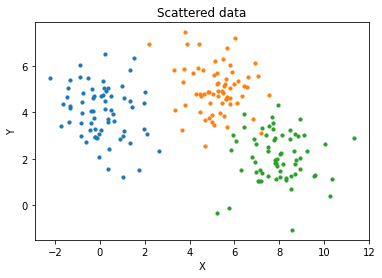

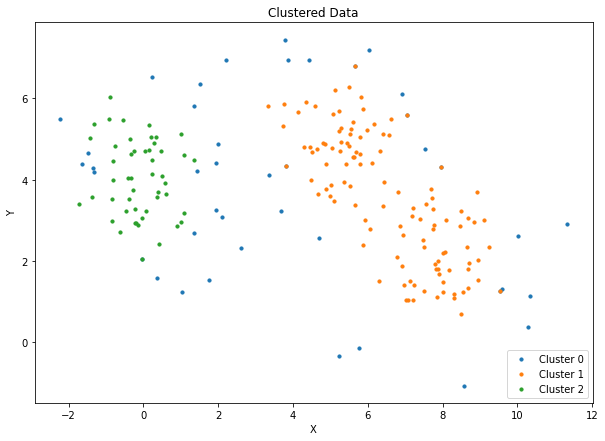

In [373]:

# Definicion de los centros para generar los datos de prueba
centers = [(0, 4), (5, 5) , (8,2)]
cluster_std = [1.2, 1, 1.1]

# Se crea una cantidad de puntos, en este caso el ejemplo
# se inicializa con 2 valores en cada dato porque son puntos
X, y= make_blobs(n_samples=200, cluster_std=cluster_std, centers=centers, n_features=2, random_state=1)

# graficación de los datos clasificados inicialemnte
plt.scatter(X[y == 0, 0], X[y == 0, 1], s=10, label="Cluster1")
plt.scatter(X[y == 1, 0], X[y == 1, 1], s=10, label="Cluster2")
plt.scatter(X[y == 2, 0], X[y == 2, 1], s=10, label="Cluster3")
plt.title("Scattered data")
plt.xlabel('X')
plt.ylabel('Y')

# parametro del radio
eps = 0.6
# parametro del minimo de vecinos
minPts = 4

# Mostrar los datos
data = pd.DataFrame(X, columns = ["X", "Y"] )
print(data.head())
print("len data", len(data))
column_names = ["X", "Y"]
clustered = cluster_with_stack(eps, minPts, data, column_names)
print(data.head())
print("len clustered", len(clustered))
new_clustered = []
for i in range(len(clustered)):
    for cluster in clustered:
        if (i == cluster[0]):
            new_clustered.append(cluster[1])
            break

idx , cluster = list(zip(*clustered))


# Ahora que se realizó el análisis, note como se muestra 
cluster_df = pd.DataFrame(clustered, columns = ["idx", "cluster"])
print(cluster_df.head(100))

# Ahora que ya se realizó el analisis se muestra la distribución de los
# clusters, note que es diferente
plt.figure(figsize=(10,7))
for clust in np.unique(cluster):
    plt.scatter(X[cluster_df["idx"][cluster_df["cluster"] == clust].values, 0], X[cluster_df["idx"][cluster_df["cluster"] == clust].values, 1], s=10, label=f"Cluster{clust}")
plt.legend([f"Cluster {clust}" for clust in np.unique(cluster)], loc ="lower right")
plt.title('Clustered Data')
plt.xlabel('X')
plt.ylabel('Y')

### 2.1) y 2.2) Carga y selección de los datos a anlizar

In [313]:
df1 = pd.read_csv('oij.csv')
df1 = df1.drop(columns=["SubDelito","Fecha","Hora","Nacionalidad","Provincia","SubVictima", "Distrito", ";;"])
df1["Canton"] = df1["Canton"].str.lower()

df1 = sqldf.sqldf("SELECT COUNT(Delito) AS CantidadDelito, Canton FROM df1 GROUP BY Canton")

print(df1.head())



   CantidadDelito      Canton
0              44   abangares
1              26      acosta
2            1115    alajuela
3             216  alajuelita
4              23    alvarado


In [314]:
def normalize(list):
    replacements = (
        ("á", "a"),
        ("é", "e"),
        ("í", "i"),
        ("ó", "o"),
        ("ú", "u"),
    )
    new_list = []
    for s in list:
        for a, b in replacements:
            s = s.replace(a, b).replace(a.upper(), b.upper())
        new_list.append(s)
    return new_list


df2 = pd.read_excel('inec.xls')
df2 = df2.drop([0, 1, 2, 3], axis=0)
df2 = df2.drop(["Unnamed: 0"], axis=1)
df2["CantonInec"] = normalize(df2["CantonInec"].str.lower())
df2 = df2.drop(columns=["Población de 15 años y más", "Tasa neta de participación", "Sector Primario", "Sector Secundario", "Sector Terciario"], axis = 1)
print(df2.head())


   CantonInec  TasaOcupacion  TasaDesempleo  PorcentajePersonasInactivas  \
4    puriscal      49.103748       3.071150                    49.340421   
5     tarrazu      49.737288       2.782839                    48.838983   
6      aserri      52.686884       3.249831                    45.543368   
7        mora      53.433918       3.229241                    44.782992   
8  goicoechea      54.698079       3.689298                    43.206645   

   RelacionDependencia   
4              1.527686  
5              1.696704  
6              1.449729  
7              1.332683  
8              1.238161  


Se realiza una unión de los datos de cada archivo

In [315]:
df = sqldf.sqldf("SELECT * FROM df1 INNER JOIN df2 ON df1.Canton = df2.CantonInec")
df = df.drop(["CantonInec"], axis=1)
print(df.head())

   CantidadDelito      Canton  TasaOcupacion  TasaDesempleo  \
0              44   abangares      44.862268       4.809683   
1              26      acosta      48.539620       2.061311   
2            1115    alajuela      53.855069       3.515977   
3             216  alajuelita      53.897432       3.784158   
4              23    alvarado      52.234480       1.515953   

   PorcentajePersonasInactivas  RelacionDependencia   
0                    52.870975              1.872910  
1                    50.438769              1.670322  
2                    44.182397              1.341712  
3                    43.982788              1.443112  
4                    46.961481              1.522827  


### 2.3) Uso del algoritmo de KMeans para caracterizar los datos 

In [316]:
# Se crea un arreglo de datos aleatorios con make_blobs que contiene la cantidad
# de centros indicada junto con la cantidad de caracteristicas dada como features
centers = 5

# copia del dataframe para el analisis
df  = pd.DataFrame(df)
df_prueba1 = df.drop(["Canton"], axis=1)

# Se aplica Kmeans
kmeans = KMeans(n_clusters=centers)
kmeans.fit(df_prueba1.to_numpy())

# Se imprimen los datos con el cluster escogido para cada uno
df_prueba1['Cluster'] = kmeans.evaluate(df_prueba1.to_numpy())[1]
print(df_prueba1.head())


   CantidadDelito  TasaOcupacion  TasaDesempleo  PorcentajePersonasInactivas  \
0              44      44.862268       4.809683                    52.870975   
1              26      48.539620       2.061311                    50.438769   
2            1115      53.855069       3.515977                    44.182397   
3             216      53.897432       3.784158                    43.982788   
4              23      52.234480       1.515953                    46.961481   

   RelacionDependencia   Cluster  
0              1.872910        1  
1              1.670322        1  
2              1.341712        3  
3              1.443112        0  
4              1.522827        1  


A continuación se muestran los cantones que terminaton en los mismos clusters

In [317]:

listaCluster = []
listaCantones= []
for i in df_prueba1.index:
    listaCluster.append(df_prueba1.iloc[i]["Cluster"])

for i in df.index:
    listaCantones.append(df.iloc[i]['Canton'])


grupos = []
for i in range(centers):
    grupos.append([])

for i in range(len(listaCantones)):
    grupos[int(listaCluster[i])].append(listaCantones[i])

for i in range(len(grupos)):
    print("\n\n Cantones en el cluster ", i)
    for j in range(len(grupos[i])):
        print(grupos[i][j], ", ", end = '')






 Cantones en el cluster  0
alajuelita , corredores , curridabat , golfito , grecia , guacimo , la union , matina , nicoya , osa , sarapiqui , talamanca , tibas , turrialba , 

 Cantones en el cluster  1
abangares , acosta , alvarado , atenas , bagaces , dota , flores , guatuso , hojancha , jimenez , la cruz , montes de oro , mora , nandayure , naranjo , palmares , poas , san isidro , san mateo , san pablo , tarrazu , tilaran , turrubares , zarcero , 

 Cantones en el cluster  2
aserri , barva , belen , buenos aires , carrillo , coto brus , el guarco , esparza , los chiles , moravia , oreamuno , orotina , paraiso , parrita , puriscal , san rafael , santa ana , santa barbara , santo domingo , upala , 

 Cantones en el cluster  3
alajuela , heredia , puntarenas , san carlos , 

 Cantones en el cluster  4
cartago , garabito , goicoechea , liberia , limon , montes de oca , perez zeledon , pococi , san ramon , santa cruz , siquirres , 

### 2.4) Método del codo para seleccionar el mejor K

A continuación el método del codo

[0, 0.1669516180276672, 0.14417169533153337, 0.12248745968236356, 0.1274990048423285, 0.12638761142970095, 0.137039777072987, 0.12354119954717492, 0.11867306454819496, 0.12116610069629137]


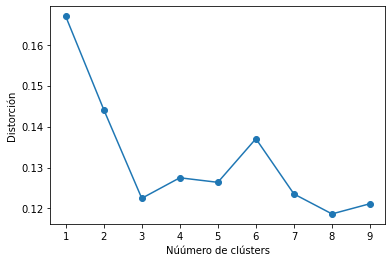

In [345]:
# Se calula el mejor k con el Algoritmo del Codo.
# calculamos la distorcion para diferentes k 

# Se calcula el error cuadrado con k diferentes (distorción)
distortions = []
for i in range(1, 11):
    km = KMeans(n_clusters=i)
    km.fit(df_prueba1.to_numpy())
    distortions.append(km.inertia)

print(distortions)
# plot
plt.plot(range(1, 10), distortions[1:], marker='o')
plt.xlabel('Núúmero de clústers')
plt.ylabel('Distorción')
plt.show()

Recordemos que entre las características de un buen modelo es uno que tiene una baja inercia y un bajo número de clusters. En este caso el valor que mejor cumple estas características es el valor 3. Ahora note el desempeño del algoritmo con 3 clusters:

In [346]:
# Se crea un arreglo de datos aleatorios con make_blobs que contiene la cantidad
# de centros indicada junto con la cantidad de caracteristicas dada como features
centers = 3

# copia del dataframe para el analisis
df  = pd.DataFrame(df)
df_prueba2 = df.drop(["Canton"], axis=1)

# Se aplica Kmeans
kmeans = KMeans(n_clusters=centers)
kmeans.fit(df_prueba2.to_numpy())

# Se imprimen los datos con el cluster escogido para cada uno
df_prueba2['Cluster'] = kmeans.evaluate(df_prueba2.to_numpy())[1]
print(df_prueba2.head())


listaCluster = []
listaCantones= []
for i in df_prueba2.index:
    listaCluster.append(df_prueba2.iloc[i]["Cluster"])

for i in df.index:
    listaCantones.append(df.iloc[i]['Canton'])


grupos = []
for i in range(centers):
    grupos.append([])

for i in range(len(listaCantones)):
    grupos[int(listaCluster[i])].append(listaCantones[i])

for i in range(len(grupos)):
    print("\n\n Cantones en el cluster ", i)
    for j in range(len(grupos[i])):
        print(grupos[i][j], ", ", end = '')

   CantidadDelito  TasaOcupacion  TasaDesempleo  PorcentajePersonasInactivas  \
0              44      44.862268       4.809683                    52.870975   
1              26      48.539620       2.061311                    50.438769   
2            1115      53.855069       3.515977                    44.182397   
3             216      53.897432       3.784158                    43.982788   
4              23      52.234480       1.515953                    46.961481   

   RelacionDependencia   Cluster  
0              1.872910        0  
1              1.670322        0  
2              1.341712        2  
3              1.443112        0  
4              1.522827        0  


 Cantones en el cluster  0
abangares , acosta , alajuelita , alvarado , aserri , atenas , bagaces , barva , belen , buenos aires , carrillo , coto brus , dota , el guarco , esparza , flores , golfito , grecia , guacimo , guatuso , hojancha , jimenez , la cruz , la union , los chiles , montes de oro , mora 

### 2.5) Utilización del algoritmo DBSCAN para caracterizar las variables seleccionadas

In [402]:
# parametro del radio
eps = 20
# parametro del minimo de vecinos
minPts = 6

# Mostrar los datos
# copia del dataframe para el analisis
df  = pd.DataFrame(df)
df_prueba3 = df.drop(["Canton"], axis=1)
columns = ["CantidadDelito", "TasaOcupacion"]
df_prueba3 = pd.DataFrame(df_prueba3, columns = columns)

clustered = cluster_with_stack(eps, minPts, df_prueba3, columns)

new_clustered = []
for i in range(len(clustered)):
    for cluster in clustered:
        if (i == cluster[0]):
            new_clustered.append(cluster[1])
            break
idx , cluster = list(zip(*clustered))


# Ahora que se realizó el análisis, note como se muestra 
cluster_df = pd.DataFrame(clustered, columns = ["idx", "cluster"])


## Mostrar resumen de los resultados
listaCluster = []
listaCantones= []
for i in cluster_df.index:
    listaCluster.append(cluster_df.iloc[i]["cluster"])

for i in df.index:
    listaCantones.append(df.iloc[i]['Canton'])

# calculo de la cantidad de clusters
num_clusters = 0
for i in new_clustered:
    if i > num_clusters:
        num_clusters = i
num_clusters+=1

grupos = []
for i in range(num_clusters):
    grupos.append([])

for i in range(len(listaCantones)):
    grupos[int(listaCluster[i])].append(listaCantones[i])

for i in range(len(grupos)):
    print("\n\n Cantones en el cluster ", i)
    for j in range(len(grupos[i])):
        print(grupos[i][j], ", ", end = '')




 Cantones en el cluster  0
abangares , acosta , nicoya , poas , pococi , puntarenas , puriscal , san carlos , san isidro , san mateo , san pablo , san rafael , san ramon , santa ana , santa barbara , santa cruz , santo domingo , sarapiqui , siquirres , talamanca , tarrazu , tibas , tilaran , turrialba , turrubares , upala , zarcero , 

 Cantones en el cluster  1
alajuela , alajuelita , alvarado , aserri , atenas , bagaces , barva , belen , buenos aires , carrillo , cartago , corredores , coto brus , curridabat , dota , el guarco , esparza , flores , garabito , goicoechea , golfito , grecia , guacimo , guatuso , heredia , hojancha , jimenez , la cruz , la union , liberia , limon , los chiles , matina , montes de oca , montes de oro , mora , moravia , nandayure , naranjo , 

 Cantones en el cluster  2
oreamuno , orotina , osa , palmares , paraiso , parrita , perez zeledon , 

### 2.6) Investigación de las formas para evaluar los algoritmos K-Means y DBSCAN

Para la validación y evaluación de los resultados de los algoritmos de clustering se tienen dos tipos de validaciones, externas e internas. La principal diferencia entre ambas es que la externa utiliza informaicón externa para la validación del producto con respecto a clasificaciones conocidas y la otra se basa en comparaciones que describen qué tan bien se hicieron los clusters.

En la práctica, la información externa por lo general no se encuentra disponible y es por esto que se recurre a un algoritmo de aprendizaje no supervisado. A continuación se dan más detalles de cada técnica.

#### Validación interna

Como el objetivo del clustering es agrupar objetos similares en el mismo cluster y objetos diferentes en difetentes cluster las técnicas de validación interna están basadas en los siguientes conceptos:

- cohesión: Es el grado de similitud entre los miembros de cada cluser.
- separación: es el grado de separación entre los miembros de clusters diferentes.

La idea de una buena formación de clusters es que se cuente con una alta cohesión y una alta separación.

Una de las técnicas de evaluación se llama Sum of Squared Within (SSW) esta corresponde a una medida de cohesión de los clusters que el algoritmo generó. 

$$SSE = \displaystyle\sum_{i=1}^{k} \displaystyle\sum_{i\epsilon C_i} dist^2(m_i,x)$$

Donde $k$ es el número de clústers, $x$ es un punto del clúster $C_i$ y $m_i$ es el centroide del clúster $C_i$

Otra de las técnicas muy similar pero para medir la separación entre clústers es Sum of Squared Between (SSB). Se calcula de esta forma:

$$SSB = \displaystyle\sum_{j=1}^{k} n_j \; dist^2(c_j\;-\; \overline x)$$

A continuación se le aplicará la métrica de SSE a ambos algoritmos, emepezando por el de KMeans



In [436]:
## Calculo de SSW en los resultados de KMeans

df_cluster0 = sqldf.sqldf("SELECT * FROM df_prueba2 WHERE Cluster = 0")
df_cluster0 = df_cluster0.drop(columns=["Cluster"], axis=1)
df_cluster1 = sqldf.sqldf("SELECT * FROM df_prueba2 WHERE Cluster = 1")
df_cluster1 = df_cluster1.drop(columns=["Cluster"], axis=1)
df_cluster2 = sqldf.sqldf("SELECT * FROM df_prueba2 WHERE Cluster = 2")
df_cluster2 = df_cluster2.drop(columns=["Cluster"], axis=1)

cluster_list = [df_cluster0, df_cluster1, df_cluster2]


SSW = 0
for i in range(len(cluster_list)):
    for j in range(len(cluster_list[i].to_numpy())):
        SSW += np.sum((kmeans.centroids[i] - cluster_list[i].to_numpy()[j])**2, axis=0)

print("SSW para el algoritmo de KMeans:")
print(SSW)


## Calculo de SSW en los resultados de DBSCAN
df_prueba3['Cluster'] = cluster_df['cluster']

df_cluster0_DB = sqldf.sqldf("SELECT * FROM df_prueba3 WHERE Cluster = 0")
df_cluster0_DB = df_cluster0_DB.drop(columns=["Cluster"], axis=1)
df_cluster1_DB = sqldf.sqldf("SELECT * FROM df_prueba3 WHERE Cluster = 1")
df_cluster1_DB = df_cluster1_DB.drop(columns=["Cluster"], axis=1)
df_cluster2_DB = sqldf.sqldf("SELECT * FROM df_prueba3 WHERE Cluster = 2")
df_cluster2_DB = df_cluster2_DB.drop(columns=["Cluster"], axis=1)

cluster_DB_list = [df_cluster0_DB, df_cluster1_DB, df_cluster2_DB]
centrids_DB = np.array([df_cluster0_DB.to_numpy()[0], df_cluster1_DB.to_numpy()[0],
                    df_cluster2_DB.to_numpy()[0]])


SSW = 0
for i in range(len(cluster_DB_list)):
    for j in range(len(cluster_DB_list[i].to_numpy())):
        SSW += np.sum((centrids_DB[i] - cluster_DB_list[i].to_numpy()[j])**2, axis=0)

print("SSW para el algoritmo de DBSCAN:")
print(SSW)


SSW para el algoritmo de KMeans:
558238.8968928881
SSW para el algoritmo de DBSCAN:
35020395.45798819


### 2.7) Compare los resultados de ambos algoritmos y genere y documente sus conclusiones

Note que en el caso del KMeans el SSW fue mucho menor, esto se puede deber a que la organización de los datos se ve más favorecida por este algoritmo. Además considere que para este algoritmo se realizó un estudio sobre la cantidad de clusters ideales. El algoritmio de DBSCAN presenta mejores distribuciones en cuanto a densidad pero solamente cuando el arreglo de los datos le permite desempeñase mejor.

Como parte de los resultados se pueden comparar los clusters generados por ambos algoritmos en la sección de este documento en donde se corrió cada respectivo algoritmo. Note que sin la necesidad de forzarlo, ambos tienen el mismo número de clusters y ambos con una cantidad similar de cantones por número de cluster. 

Con base en los resultados y la experiencia del desarrollo de este ejercicio se presentan las siguientes conclusiones:

- Los algoritmos de clustering permiten resolver un problema común como lo es explorar un área poco investigada, ya que estos son capaces de clasificar la información sin necesidad de conocer categorías de antemano. En este ejercicio se tomaton dos conjuntos de datos separados y a partir de ellos se pudo llegar a clasificaciones que antes no se conocían.

- El desarrollo de estos algoritmo es mejor entre más datos se conozcan sobre cada uno de los cantones, este problema se limitó a 5 variables a considerar pero fue simplemente para que no fuera un proyecto tan complejo y también porque los datos que se tomaron inicialemnte tampoco tenían una cantidad considerable atributos como para hacer la investigación más robusta.

- Los algoritmos de KMeans y DBSCAN se diferencian en la forma en que clasifican la información, el de Kmeans trata de enfocarse en la cecanía de los datos mientras que el DBSCAN en la densidad de un conjunto de los mismos. El desempeño de cada algoritmo puede variar dependiendo del conjunto de datos como se pudo mencionar en la sección de resultados.

- Las formas en las que se pueden evaluar los algoritmos implementados dependen de la cercanía de los datos en un mismo clusteer y la lejanía con los datos de un clúster aparte. En el caso de este ejemplo se obtuvo una mayor cercanía entre los datos de los clúster para KMeans y esto se debe a la distribución de los datos en este caso.

## Referencias

- Ayuda algoritmo KMeans: https://datascience.stackexchange.com/questions/48693/perform-k-means-clustering-over-multiple-columns

- https://towardsdatascience.com/create-your-own-k-means-clustering-algorithm-in-python-d7d4c9077670


- Ayuda algoritmo DBSCAN: https://github.com/Moosa-Ali/DBscan-Clustering-Implementation/blob/main/DBSCAN%20implementation.ipynb

- Metricas: https://disi.unal.edu.co/~eleonguz/cursos/mda/presentaciones/validacion_Clustering.pdf

- numpy documentation: https://numpy.org/doc/

- pandas documentation: https://pandas.pydata.org/docs/

- clases de la profe
